Populating the interactive namespace from numpy and matplotlib


/home/liamk/anaconda2/envs/davitpy_latest/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


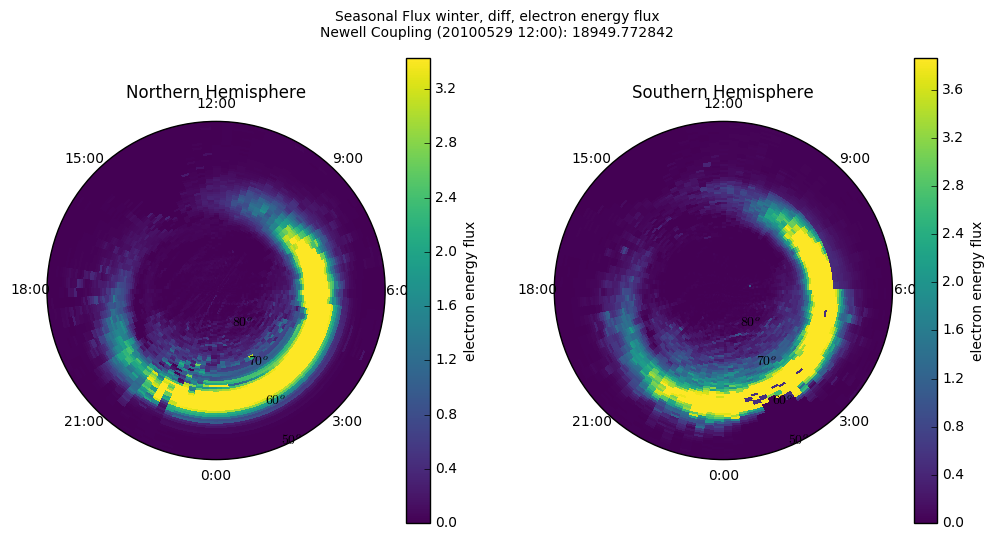

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from ovationpyme.ovation_prime import SeasonalFluxEstimator,BinCorrector
from ovationpyme.ovation_utilities import calc_avg_solarwind
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux
import ipywidgets
from collections import OrderedDict
from functools import partial

seasons = ['winter','spring','summer','fall']
auroral_types = ['diff','mono','wave','ions']
flux_types = [
                "electron energy flux",
                "ion energy flux",
                "electron number flux",
                "ion number flux",
                "electron average energy",
                "ion average energy"
            ]

def plot_seasonal_fluxes_callback(clicked_button,widgets):
    f = plt.figure(figsize=(12,6),dpi=150)
    axN = f.add_subplot(121,projection='polar')
    axS = f.add_subplot(122,projection='polar')
    season = widgets['season_select'].value
    atype = widgets['atype_select'].value
    jtype = widgets['jtype_select'].value
    bincorrect = widgets['bincorrect_toggle'].value
    year = widgets['year'].value
    month = widgets['month'].value
    day = widgets['day'].value
    hour = widgets['hour'].value
    minute = widgets['minute'].value
    dt = datetime.datetime(year,month,day,hour,minute)
    dtstr = dt.strftime('%Y%m%d %H:%M')
    avg_sw = calc_avg_solarwind(dt)
    estimator = SeasonalFluxEstimator(season,atype,jtype)
    fluxtuple = estimator.get_gridded_flux(avg_sw['Ec'],combined_N_and_S=False)
    mlatgridN,mltgridN,fluxgridN,mlatgridS,mltgridS,fluxgridS = fluxtuple
    if bincorrect:
        bcN = BinCorrector(mlatgridN,mltgridN)
        fluxgridN = bcN.fix(fluxgridN)
        bcS = BinCorrector(mlatgridS,mltgridS)
        fluxgridS = bcS.fix(fluxgridS)
        print("Correction Applied")    
    pcolor_kwargs = {'cmap':'viridis'}
    manual_vmin = wgts['vmin_float'].value
    if manual_vmin != -1.:
        pcolor_kwargs['vmin']=manual_vmin
    manual_vmax = wgts['vmax_float'].value
    if manual_vmax != -1.:
        pcolor_kwargs['vmax']=manual_vmax
    mappableN = pcolor_flux(axN,mlatgridN,mltgridN,fluxgridN,'N',**pcolor_kwargs)
    mappableS = pcolor_flux(axS,mlatgridS,mltgridS,fluxgridS,'S',**pcolor_kwargs)
    f.colorbar(mappableN,ax=axN,label=jtype)
    f.colorbar(mappableS,ax=axS,label=jtype)
    axN.set_title('Northern Hemisphere')
    axS.set_title('Southern Hemisphere')
    polar2dial(axN)
    polar2dial(axS)
    f.suptitle(('Seasonal Flux %s, %s, %s' % (season,atype,jtype)
                +'\nNewell Coupling (%s): %f' % (dtstr,avg_sw['Ec'])))
    plt.show()
    

wgts = OrderedDict()
wgts['year']=ipywidgets.IntText(description='Year',value=2010)
wgts['month']=ipywidgets.IntText(description='Month',value=5)
wgts['day']=ipywidgets.IntText(description='Day',value=29)
wgts['hour']=ipywidgets.IntText(description='Hour',value=12)
wgts['minute']=ipywidgets.IntText(description='Minute',value=0)
wgts['season_select']=ipywidgets.Dropdown(options=seasons,description='Season')
wgts['atype_select']=ipywidgets.Dropdown(options=auroral_types,description='Type of Aurora')
wgts['jtype_select']=ipywidgets.Dropdown(options=flux_types,description='Type of Flux')
wgts['vmin_float']=ipywidgets.FloatText(description='Colorbar Min (-1 is Autoscale)',value=-1)
wgts['vmax_float']=ipywidgets.FloatText(description='Colorbar Max (-1 is Autoscale)',value=-1)
wgts['bincorrect_toggle']=ipywidgets.ToggleButton(description='Correction',value=False)
wgts['run_button'] = ipywidgets.Button(description='Calculate')
wgts['run_button'].on_click(partial(plot_seasonal_fluxes_callback,widgets=wgts))

for widget_name,widget in wgts.iteritems():
    display(widget)